<a href="https://colab.research.google.com/github/crazycloud/dl-learning/blob/main/Normalization_in_Deep_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Why Normalization is used?
Normalization techniques are used to improve the stability of training neural nets and to improve performance. It address the internal covariate shift problem during training.

## What is covariate shift?

The covariate shift problem refers to a phenomenon that can occur during the training of neural networks. It arises when the distribution of the input data (activations) to each layer of the network changes during training. This **change in the distribution of input data at each layer can make it more challenging** for the network to converge and learn effectively.

This change in distribution can be problematic for the network's learning process because the model might have difficulty in generalizing well to unseen data. The network might converge slowly, or it could even fail to converge altogether. As a result, the training process becomes less efficient and may require additional iterations or adjustments in learning rate to achieve good performance.


## Batch Normalization

For each layer in the neural network, batch normalization normalizes the activations by adjusting them to have a standardized mean and variance.

- Normalization within a batch: During the training process, the input data is divided into batches. For each batch, **the mean and variance of the activations within that batch are computed**. The activations are then normalized based on the statistics (mean and variance) of the current batch.

- Learnable parameters: Batch normalization introduces learnable parameters, **scale, and shift parameters, which allow the network to learn the appropriate scaling and shifting** for the normalized activations.


By normalizing the activations within each batch, the network becomes less sensitive to the changes in the input data distribution that occur during training. This helps in faster convergence, better generalization, and overall more stable training of deep neural networks.




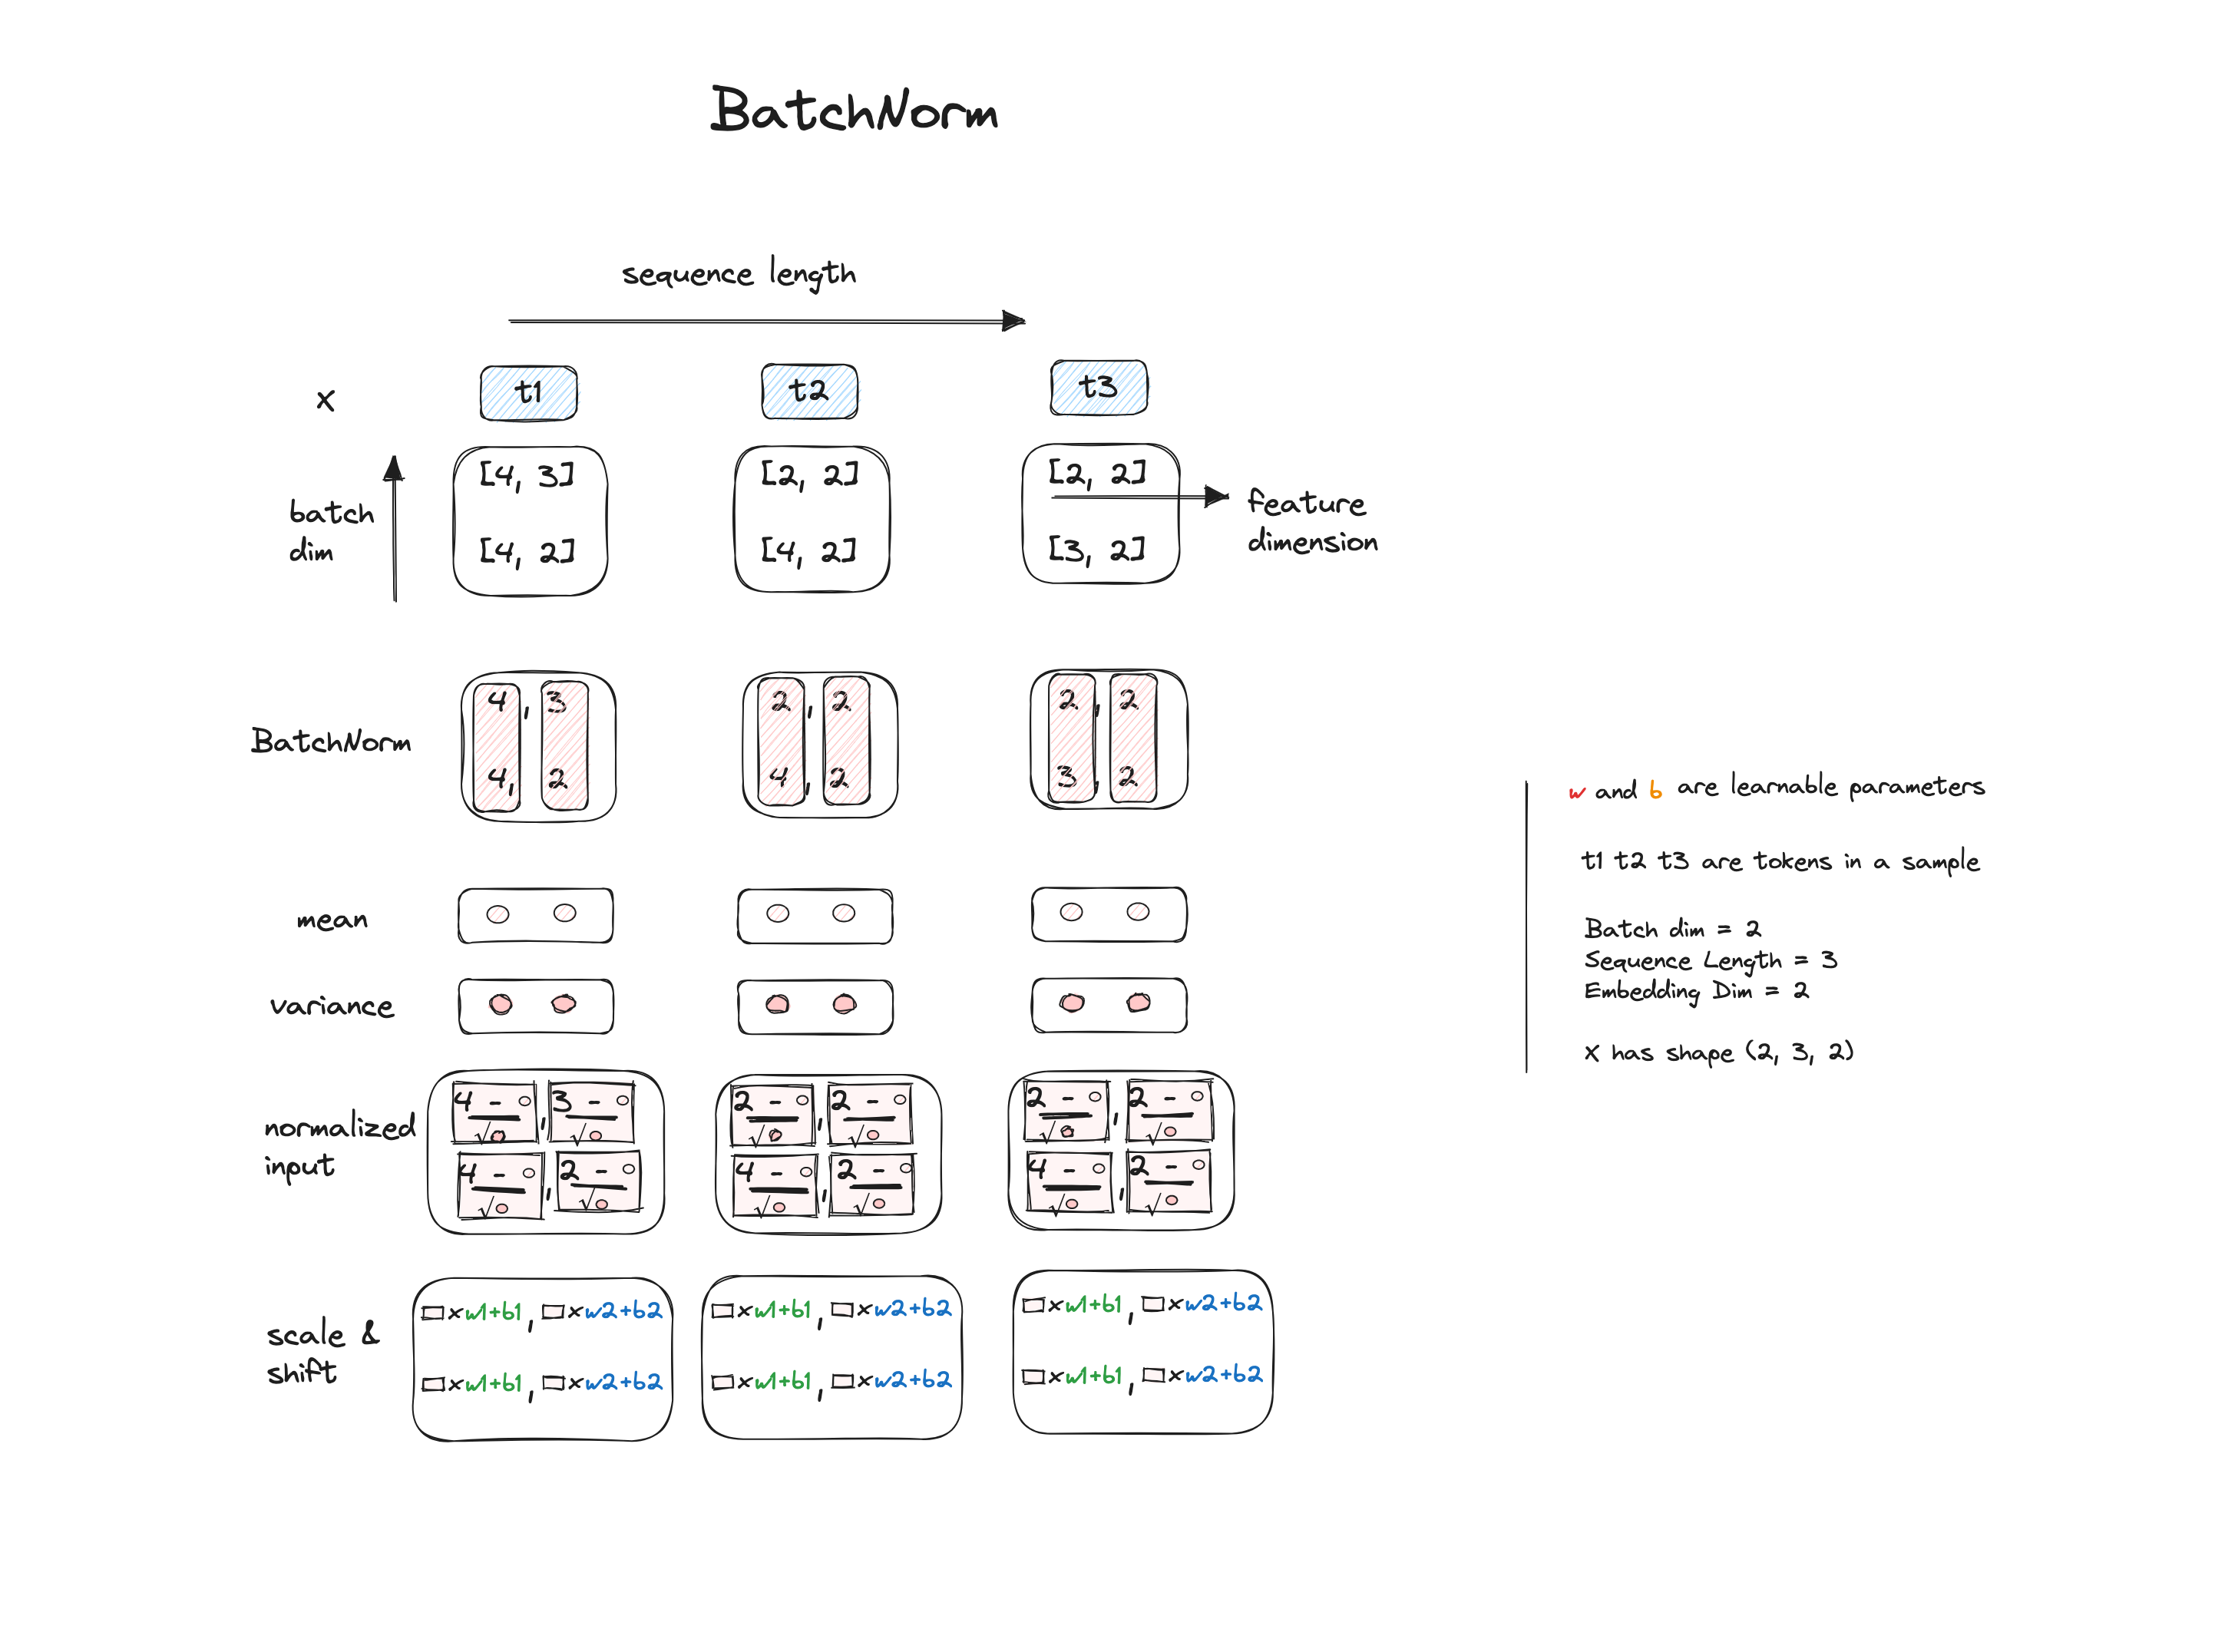

In [2]:
import torch
import torch.nn as nn

class BatchNorm(nn.Module):
    def __init__(self, emb, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.eps = eps
        self.momentum = momentum # weightage on current mean/variance vs running value
        self.register_buffer('running_mean', torch.zeros(emb))
        self.register_buffer('running_var', torch.ones(emb))
        self.weight = nn.Parameter(torch.ones(emb))  # Learnable scale parameter
        self.bias = nn.Parameter(torch.zeros(emb))   # Learnable shift parameter

    def forward(self, a):
        if self.training:
            mean = a.mean(dim=0, keepdim=True)
            variance = a.var(dim=0, unbiased=False, keepdim=True)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.squeeze() # running mean across multiple batches
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance.squeeze() # running variance across multiple batches
        else:
            mean = self.running_mean.view(1, -1)
            variance = self.running_var.view(1, -1)

        normalized_input = (a - mean) / torch.sqrt(variance + self.eps)
        output = self.weight * normalized_input + self.bias
        return output



## Layer Normalization

Layer normalization is another technique used to normalize activations in neural networks. While batch normalization normalizes activations within a batch, **layer normalization normalizes activations across the features within a single sample**, regardless of the batch size.

LayerNorm(LN) is typically used in NLP tasks. The statistics of NLP data across the batch dimension exhibit large fluctuations compared to CV task throughout training. This results in instability when using BatchNorm(BN). The Attention is All you Need paper used LN as the default normalization scheme.


![Alt text](https://i.stack.imgur.com/E3104.png)

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, emb, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(emb))  # Learnable scale parameter
        self.bias = nn.Parameter(torch.zeros(emb))   # Learnable shift parameter

    def _norm(self, x):
        mean = a.mean(-1, keepdim=True)
        variance = a.var(dim=-1, unbiased=False, keepdim=True)
        return (a - mean) / torch.sqrt(variance + self.eps)

    def forward(self, a):
        return self.weight * self._norm(a) + self.bias

## Root Mean Square Normalization (RMSNorm)


The **llama and llama2 architecture uses RMNorm** instead of LayerNorm.

LayerNorm introduces some computational overhead. While it might be small for shallow neural networks with few norm layers, this overhead becomes substantial as underlying models grow larger and deeper. Consequently, the efficiency benefit of faster and more stable training enabled by LayerNorm can be offset by the increased cost per training step.

One main finding behind RMSNorm is that **mean normalization in LayerNorm doesn't reduce the variance of hidden states or model gradients**. It has little impact on the stabilization.

**RMSNorm reduces the amount of computation and increases efficiency over LayerNorm**. Despite the
simpler formulation, the RMS normalizer helps stabilize the magnitude of layer activations, ensuring invariance to the re-scaling of both weights and datasets



In [4]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(dim))

    def _norm(self, a):
        return a * torch.rsqrt(a.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(a.float()).type_as(a)
        return output * self.weight
